# Homework 4
___
### Antonio Castañares Rodríguez, A20599898

### Due date: 10/20/2024
___


In [ ]:
import math
import matplotlib.pyplot as plt

class ag: # AutoGrad

    def abs(input):
        output = ag.Scalar(math.fabs(input.value), inputs=[input], op="abs")

        def _backward():
            # Backward for abs: the gradient is 1 if input > 0, and -1 if input < 0
            input.grad += output.grad * (1 if input.value >= 0 else -1)

        output._backward = _backward
        return output


    def log(input):
        output = ag.Scalar(math.log(input.value), inputs=[input], op="log")

        def _backward():
            input.grad += output.grad / input.value
            return None

        output._backward = _backward
        return output

    def exp(input):

        output = ag.Scalar(math.exp(input.value), inputs=[input], op="exp")

        def _backward():
            input.grad += output.grad * output.value
            return None

        output._backward = _backward
        return output

    def relu(input):
        output = ag.Scalar(max(0, input.value), inputs=[input], op="relu")

        def _backward():
            if input.value > 0:
                input.grad += output.grad
            return None

        output._backward = _backward
        return output

    class Scalar: # Scalars with grads
        def __init__(self,
                     value,
                     op="",
                     _backward= lambda : None,
                     inputs=[],
                     label=""):

            self.value = float(value)
            self.grad = 0.0

            self._backward = _backward
            self.inputs = inputs

            self.op = op
            self.label = label



        def backward(self):
            self.grad = 1.0

            topo_order = self.topological_sort()

            for node in reversed(topo_order):
                node._backward()

        def topological_sort(self):
            topo_order = []
            visited = set()

            def dfs(node):
                if node not in visited:
                    visited.add(node)
                    for input in node.inputs:
                        dfs(input)
                    topo_order.append(node)

            dfs(self)
            return topo_order


        def __add__(self, other):
            if not isinstance(other, ag.Scalar):
                other = ag.Scalar(other, label=f"{other}\nconst")

            output = ag.Scalar(self.value + other.value,
                               inputs=[self, other], op="add")

            def _backward():
                # pass
                self.grad += output.grad
                other.grad += output.grad

            output._backward = _backward
            return output


        def __mul__(self, other):
            if not isinstance(other, ag.Scalar):
                other = ag.Scalar(other, label=f"{other}\nconst")

            output = ag.Scalar(self.value * other.value,
                               inputs=[self, other], op="mul")

            def _backward():

                self.grad += other.value * output.grad
                other.grad += self.value * output.grad

                return None

            output._backward = _backward

            return output

        def __truediv__(self,other):
            return self*(other**(-1))

        def __neg__(self):
            output = ag.Scalar(-self.value, inputs=[self], op="neg")
            def _backward():
                self.grad -= output.grad
                return None
            output._backward = _backward
            return output
        def __sub__(self,other):
            return self + -other

        def __pow__(self, exponent): # exponent is just a python float
            output = ag.Scalar(self.value ** exponent, inputs=[self], op=f"pow({exponent})")

            def _backward():

                self.grad += (exponent * self.value**(exponent-1)) * output.grad
                return None

            output._backward = _backward
            return output

        def __repr__(self) -> str:
            if self.op == "":
                return self.label
            else:
                return self.label + "\n" + self.op


# Visualization code not needed

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def build_computation_graph(final_scalar):
    graph = nx.DiGraph()

    # DFS
    topo_order = final_scalar.topological_sort()

    # Count how many leaves
    # By convention, we hand-label our inputs
    # constants are labeled automatically
    labeled_nodes = [node for node in topo_order if node.label != "" and 'const' not in node.label]
    index = len(labeled_nodes) + 1

    for node in topo_order:
        if not node.label:  # If a node has no label, assign one
            node.label = f"z{index}"
            index += 1

        graph.add_node(node)
        if len(node.inputs) > 1:
            for idx, input_node in enumerate(node.inputs):
                graph.add_edge(input_node, node)
        elif len(node.inputs) == 1:
            graph.add_edge(node.inputs[0], node)

    return graph

def plot_computation_graph(graph, rad=0.2,node_size=2000):
    node_labels = {node: node.label + "\n" + node.op if node.op != "" else node.label for node in graph.nodes}

    # Assign layers to nodes for multipartite layout
    for layer, nodes in enumerate(nx.topological_generations(graph)):
        for node in nodes:
            graph.nodes[node]["layer"] = layer

    pos = nx.multipartite_layout(graph, subset_key="layer")

    node_colors = []
    node_edge_colors = []

    for node in graph.nodes:
        if "leaf" in node.label:
            node_colors.append('none')  # Input nodes: no fill
            node_edge_colors.append('black')
        elif "const" in node.label:
            node_colors.append('none')
            node_edge_colors.append('lightgray')
        else:
            node_colors.append('lightblue')
            node_edge_colors.append('none')

    curved_edges = []
    straight_edges = []

    for node in graph.nodes:
        incoming_edges = list(graph.in_edges(node))
        if len(incoming_edges) > 1:
            curved_edges.extend(incoming_edges)
        else:
            straight_edges.extend(incoming_edges)

    # Draw straight edges
    nx.draw(graph, pos, with_labels=False, edgelist=straight_edges,
            node_color=node_colors, edgecolors=node_edge_colors, node_size=node_size,
            font_size=10, font_weight='bold', arrows=True)

    # Draw curved edges with a specified curvature
    nx.draw(graph, pos, with_labels=False, edgelist=curved_edges,
            connectionstyle=f'arc3, rad={rad}', node_color=node_colors,
            edgecolors=node_edge_colors, node_size=node_size, font_size=10,
            font_weight='bold', arrows=True)

    nx.draw_networkx_labels(graph, pos=pos, labels=node_labels)


# Demo of the visulization code

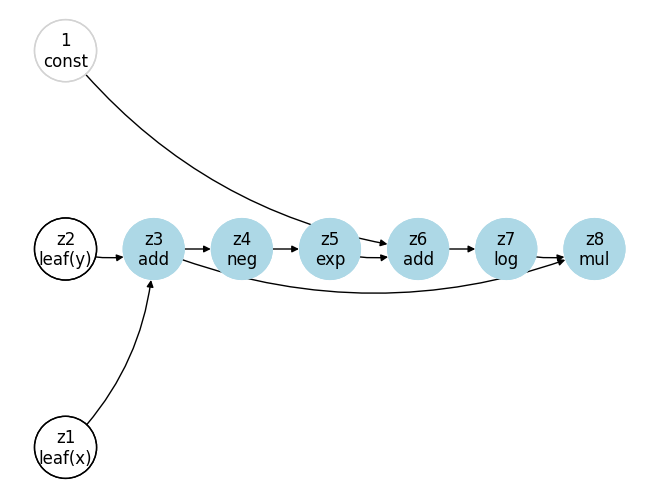

In [ ]:
x = ag.Scalar(2.0, label="z1\nleaf(x)")  # z1
y = ag.Scalar(3.0, label="z2\nleaf(y)")  # z2

z1 = x
z2 = y

z3 = x+y

final_output = z3*ag.log(ag.exp(-(z3))+1)


computation_graph = build_computation_graph(final_output)
plot_computation_graph(computation_graph,0.2)

In [ ]:
dfs_node_ordering = final_output.topological_sort()
[dfs_node_ordering[i].__repr__().replace("\n",":") for i in range(len(dfs_node_ordering))]

['z1:leaf(x)',
 'z2:leaf(y)',
 'z3:add',
 'z4:neg',
 'z5:exp',
 '1:const',
 'z6:add',
 'z7:log',
 'z8:mul']

# Problem 3 Gradient descent [10pts]




Consider the following extremely simple model: The model $f ( x ; \theta )$ has only a single real-valued parameter $\theta = b$ where $b \in \mathbb{R}$.
Regardless of the input,
the model always outputs $b$, i.e., $f(x ; \theta) = b$ for all $x$.
Suppose that we have $N=5$ samples. Moreover, the labels are
$$
y^{(1)} = 3, \quad y^{(2)} = 6 \quad y^{(3)} = 8.5 \quad y^{(4)} =11 \quad y^{(5)} = 16
$$
Using ag.Scalar, compute 10 iterations of (full batch) gradient descent on the empirical risk/loss function
$$
  \textstyle
  J(b) =
\frac{1}{N}\sum_{i=1}^{N}  | y^{(i)} - b|.
$$
Use $b = 0$ as initialization and $\eta = 5$ as the step size.


The loss derivative is
$$
  \frac{\partial}{\partial b}
| y - b|
=
\begin{cases}
  -1 &: \text{ if $b \le y$ } \\
  1 &: \text{ if $b > y$ }. \\
\end{cases}
$$
Note: the step size $\eta = 5$ is rather large and is not typical in actual usage.


## Your tasks
- implement the absolute value function in the `ag` class on line 7 in the first code block. Currently, it doesn't do anything.
- complete the following training loop

In [ ]:
yvals = [3, 6, 8.5, 11, 16]
bval = 0
bvals = [bval]
eta = 5
y = [ag.Scalar(v) for v in yvals]
b = ag.Scalar(bval)

# ONLY MODIFY THE INTERIOR OF THE FOR LOOP

# --- Function to derivate ---> loss = 1 / n * sum(abs(y - b))

for t in range(10):
    loss = ag.Scalar(0.0)
    for i in range(len(yvals)):
        z1, z2 = y[i], b
        z3 = z1 - z2
        z4 = ag.abs(z3)                 # z4 stores the absolute error
        loss += z4                      # loss stores the sum of the absolute differences: sum(abs(y - b))

    loss = loss / len(yvals)            # Now, loss stores the average of the absolute differences (the all function): 1 / n * sum(abs(y - b))
    # Start the backpropagation
    loss.backward()
    # Compute and update the value of b
    bval = b.value - eta * b.grad
    bvals.append(bval)
    b = ag.Scalar(bval)

# ONLY MODIFY THE INTERIOR OF THE FOR LOOP

bvals


[0, 5.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0]

# Expected output


In [ ]:
# bvals
# [0, 5.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0]

# Problem 4 Transformer [bonus 20pts]


Calculate using `ag.Scalar` the following: `dJdw3` `dJdW2` and `dJdW1` from homework 3. Use the configuration/data below.

`X_raw` corresponds to `X` from homework 3.

`y_raw` corresponds to `y` from homework 3.

And so on.

Do not change the following block.

In [ ]:
n_context = 4
n_features = 3
n_samples = 5
n_reduced = 2

X_raw = [[[-0.707, -0.707, 1.0],
          [0.963, -0.268, 1.0],
          [0.391, 0.92, -1.0],
          [0.899, 0.437, -1.0]],
         [[0.327, -0.945, 1.0],
          [0.3, -0.954, -1.0],
          [-0.485, -0.874, -1.0],
          [-0.694, 0.72, 1.0]],
         [[-0.309, 0.951, -1.0],
          [-0.951, 0.31, 1.0],
          [-0.9, -0.437, 1.0],
          [-0.013, -1.0, -1.0]],
         [[0.829, -0.559, -1.0],
          [-0.856, 0.518, 1.0],
          [-0.2, -0.98, -1.0],
          [-0.842, -0.539, 1.0]],
         [[-0.938, -0.346, 1.0],
          [-0.742, 0.67, -1.0],
          [0.742, 0.67, -1.0],
          [0.322, 0.947, -1.0]]]

y_raw = [-1.0, -1.0, 1.0, 1.0, -1.0]

W1_raw = [[0.74, 0.529], [-0.589, 0.189], [-0.759, -0.933]] # n_features by n_reduced
W2_raw = [[0.504, 0.651], [-0.319, -0.848], [0.606, -2.018]] # n_features by n_reduced
w3_raw = [2.707, 0.628, 0.908] # n_features

## Expected output

In [ ]:
# output of forward
# [ 1.6528977 , -0.50304305, -1.54629904, -1.18000691,  0.74528666]

# dJdw3
# [ 0.29006619,  0.31213455, -0.22591685]

# dJdW2
# [[ 0.05486582,  0.13401244],
#  [-0.01348159, -0.00905539],
#  [ 0.01421121,  0.01478831]]


# dJdW1
# [[ 0.02673784,  0.01136829],
#  [ 0.04348804,  0.05114747],
#  [-0.06112444, -0.05294486]]

## Your code

$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( X^{(i)\top} W^{(2)\top } W^{(1)} x^{(i,C)})
$$

X_raw = X (n_samples,n_context,n_features) (5,4,3)

y_raw = y (n_samples) (5)

W1_raw = W1 (n_features,n_reduced) (3,2)

W2_raw = W2 (n_features,n_reduced) (3,2)

w3_raw = w3 (n_features,n_reduced) (3)

In [ ]:
# Convert input data to ag.Scalar objects
X = [[[ag.Scalar(val) for val in row] for row in sample] for sample in X_raw]
y = [ag.Scalar(val) for val in y_raw]
W1 = [[ag.Scalar(val) for val in row] for row in W1_raw]
W2 = [[ag.Scalar(val) for val in row] for row in W2_raw]
w3 = [ag.Scalar(val) for val in w3_raw]

In [ ]:
# --------------------------------------------------------- #
#                                                           #
# ---------------------Auxiliary functions----------------- #
#                                                           #
#---------------------------------------------------------- #

# X @ W1
def first_operation(X, W):
    result = [[[ag.Scalar(0.0) for _  in range(n_reduced)] for _ in range(1)]for _ in range(n_samples)]
    for i in range(n_samples):
        for k in range(n_reduced):
            for l in range(n_features):
                result[i][0][k] += X[i][-1][l] * W[l][k]
    return result

# X @ W2
def second_operation(X, W):
    result = [[[ag.Scalar(0.0) for _  in range(n_reduced)] for _ in range (n_context)] for _ in range(n_samples)]
    for i in range(n_samples):
        for j in range(n_context):
            for k in range(n_reduced):
                for l in range(n_features):
                    result[i][j][k] += X[i][j][l] * W[l][k]
    return result

# Q @ K
def third_operation(q,k):
    result = [[[ag.Scalar(0.0) for _ in range(1)] for _ in range(n_context)] for _ in range(n_samples)]
    for i in range(n_samples):
        for j in range(n_context):
            for m in range(n_reduced):
                result[i][j][0] += q[i][0][m] * k[i][j][m]
    return result

# exp(Q @ K)
def fourth_operation(qk):
    result = [[[ag.exp(qk[i][j][0]) for _ in range(1)] for j in range(n_context)] for i in range(n_samples)]
    for i in range(n_samples):
        for j in range(n_context):
            result[i][j][0] += ag.exp(qk[i][j][0])
    return result

# softmax(K @ p)
def fifth_operation(sofmaxKp, expKq):
    sum = [[[ag.Scalar(0) for _ in range(1)] for _ in range(1)] for _ in range(n_samples)]

    for i in range(n_samples):
        for j in range(n_context):
            sum[i][0][0] += expKq[i][j][0]

    for i in range(n_samples):
        for j in range(n_context):
            sofmaxKp[i][j][0] += expKq[i][j][0] / sum[i][0][0]

    return sofmaxKp

# softmax(K @ p) @ X @ w3
def last_operation(zi,X, w3):
    result = [[ag.Scalar(0.0)for _ in range(1)] for _ in range(n_samples)]
    for i in range(n_samples):
        for j in range(n_context):
            for k in range(n_features):
                result[i][0] += zi[i][j][0] * X[i][j][k] * w3[k]
    return result

In [ ]:
# f(x,y) = w3 * X * softmax(X * W2 * W1 * X)
query = first_operation(X, W1) # W1 * X = (5,1,2)
key = second_operation(X, W2) # X * W2 = (5,4,2)
exp = third_operation(query, key) # X * W2 * W1 * X = (5,4,1)
expKp = fourth_operation(exp) # (5,4,1)
sofmaxKp = [[[ag.Scalar(0.0) for _ in range(1)] for _ in range(n_context)] for _ in range(n_samples)] # (5,4,1)
zi = fifth_operation(sofmaxKp,expKp) # softmax(X * W2 * W1 * X) = (5,4,1)
output = last_operation(zi,X, w3) # w3 * X * softmax(X * W2 * W1 * X) = (5,1)
result = []
for i in range(n_samples):
    result.append(output[i][0].value) # [ 1.6528977 , -0.50304305, -1.54629904, -1.18000691,  0.74528666]

print(result)

[1.6528976967412956, -0.5030430458474212, -1.5462990368860332, -1.1800069124499615, 0.7452866621253758]


In [ ]:
loss = ag.Scalar(0)
for i in range(n_samples):
    loss += ag.log(ag.exp(-output[i][0] * y[i]) + 1)

loss = loss / n_samples
loss.backward()

# Extract gradients
dJdw3 = [w.grad for w in w3]
dJdW2 = [[w.grad for w in row] for row in W2]
dJdW1 = [[w.grad for w in row] for row in W1]
# Print the gradients
print("Gradients with respect to w3:", dJdw3) #[ 0.29006619,  0.31213455, -0.22591685]
print("Gradients with respect to W2:", dJdW2) #[[ 0.05486582,  0.13401244],
                                              # [-0.01348159, -0.00905539],
                                              # [ 0.01421121,  0.01478831]]
print("Gradients with respect to W1:", dJdW1) #[[ 0.02673784,  0.01136829],
                                              # [ 0.04348804,  0.05114747],
                                              # [-0.06112444, -0.05294486]]

Gradients with respect to w3: [0.2900661907172972, 0.31213455010706614, -0.22591685346105916]
Gradients with respect to W2: [[0.054865824856022004, 0.13401244132939366], [-0.013481593347640033, -0.009055390598639452], [0.014211207749059884, 0.014788313958514375]]
Gradients with respect to W1: [[0.02673784282047291, 0.011368294676590247], [0.043488040049078296, 0.05114747020150544], [-0.06112443715812872, -0.05294485874898041]]
